## Figure 4
### Networks built on the sample from canonical corpus of the 1830s and periodicals corpus

In [2]:
library(tidyverse)
#library(tidytext)
#library(topicmodels)

#library(tidygraph)

library(igraph)
#library(sna)
library(ggraph)
library(ggplotify)

library(wesanderson)
library(patchwork)
theme_set(theme_minimal())

In [8]:
# load model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

In [9]:
# load sampled data for 1830s
load("../data/gamma_1830.Rda")
glimpse(gamma1830)

Rows: 177,300
Columns: 8
$ index   <chr> "N_6701-1", "N_6701-1", "N_6701-1", "N_6701-1", "N_6701-1", "N…
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "6701-1", "6701-1", "6701-1", "6701-1", "6701-1", "6701-1", "6…
$ year    <chr> "1830", "1830", "1830", "1830", "1830", "1830", "1830", "1830"…
$ author  <chr> "АВКольцов", "АВКольцов", "АВКольцов", "АВКольцов", "АВКольцов…
$ formula <chr> "anapaest_регулярная:2+1", "anapaest_регулярная:2+1", "anapaes…
$ topic   <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…
$ gamma   <dbl> 0.008695652, 0.008695652, 0.008695652, 0.008695652, 0.00869565…


#### Data preparation

In [10]:
# create topic labels
topic_labels <- get_topic_labels(beta, n_labels = 5)

# create edges
edges_1830 <- compute_edges(gamma1830,
                           gamma_thresh = 0.05,
                           time_slice = 5)

# select top meters
meter_counts_1830 <- gamma1830 %>% 
  rename("meter" = "formula") %>% 
  filter(!str_detect(meter, "other") & meter != "NA") %>% 
  group_by(meter, corpus) %>% 
  count(sort = T) %>% 
  mutate(n_texts = n/75) %>%
  ungroup() %>% 
  filter(n > 10)

top_meters_1830 <- meter_counts_1830 %>% 
  group_by(meter) %>%
  summarise(total = sum(n)) %>% 
  arrange(desc(total))

# create edges for 8 meters
links_1830 <- edges_1830 %>% 
  mutate(meter = formula) %>%
  # filter out only 8 most interesting meters
  filter(meter %in% top_meters_1830$meter[1:8]) %>% 
  # group and count edges
  group_by(meter, corpus) %>% 
  count(meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
head(links_1830)

meter,corpus,edge_id,source,target,n
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
iamb_free,P,30 42,30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,10
iamb_4,P,8 74,8_звезда небо луна ночь луч,74_луч солнце небо заря блистать,9
iamb_4,N,30 42,30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,8
iamb_4,P,24 72,24_вода луг тень ручей роща,72_гора лес скала дикий стоять,8
iamb_4,P,30 74,30_небо земля мир земной небесный,74_луч солнце небо заря блистать,8
trochee_4,P,8 26,8_звезда небо луна ночь луч,26_волна море берег вода брег,8


Nodelist and edgelist

In [11]:
edges_rnc <- links_1830 %>% 
    mutate(meter_edge = paste0(meter, "__", edge_id)) %>% 
    filter(corpus == "N") %>% 
    pull(meter_edge)

edges_per <- links_1830 |> 
    mutate(meter_edge = paste0(meter, "__", edge_id)) %>% 
    filter(corpus == "P") %>% 
    pull(meter_edge)

# extract intersected edges
edges_intersection <- intersect(edges_rnc, edges_per)
print("Intersection between built edges:")
head(edges_intersection)

[1] "Intersection between built edges:"


[1] "iamb_4__30 42" "iamb_4__12 42" "iamb_4__10 27" "iamb_4__12 55"
[5] "iamb_4__21 24" "iamb_4__27 54"

In [14]:
edgelist <- links_1830 %>% 
    mutate(meter_edge = paste0(meter, "__", edge_id),
            # create a column indicating if an edge is present in both corpora
          group = ifelse(meter_edge %in% edges_intersection, "Both corpora", "Unique edge")) %>% 
    select(source, target, n, meter, corpus, group) %>% 
    mutate(width = n/10,
          corpus_fullname = ifelse(corpus == "P", "Periodicals", "RNC"))

nodelist <- tibble(source = unique(c(links_1830$target, 
                                     links_1830$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

### Network

In [15]:
net1830 <- graph_from_data_frame(d = edgelist, vertices = nodelist, directed = F)
net1830

IGRAPH 8123988 UN-- 73 638 -- 
+ attr: name (v/c), idn (v/n), n (e/n), meter (e/c), corpus (e/c),
| group (e/c), width (e/n), corpus_fullname (e/c)
+ edges from 8123988 (vertex names):
[1] 42_душа мечта поэт живой восторг--30_небо земля мир земной небесный     
[2] 74_луч солнце небо заря блистать--8_звезда небо луна ночь луч           
[3] 42_душа мечта поэт живой восторг--30_небо земля мир земной небесный     
[4] 72_гора лес скала дикий стоять  --24_вода луг тень ручей роща           
[5] 74_луч солнце небо заря блистать--30_небо земля мир земной небесный     
[6] 26_волна море берег вода брег   --8_звезда небо луна ночь луч           
[7] 42_душа мечта поэт живой восторг--12_любовь сердце страсть кровь чувство
+ ... omitted several edges

Create labels

In [22]:
# Network densities
density_vector <- function(formula) {
    densities <- vector()
    e1 <- NULL
    for (i in 1:length(unique(edgelist$corpus))) {
        e1 <- edgelist %>% 
            filter(meter == formula & corpus == unique(edgelist$corpus)[i])

            net_test <- graph_from_data_frame(d = e1, vertices = nodelist, directed = F)

            densities[i] <- edge_density(net_test, loops = F)
    }
    densities
}

densities <- tibble(
      corpus = c("P", "N"),
      iamb_4 = round(density_vector("iamb_4"), 3),
      iamb_6 = round(density_vector("iamb_6"), 3),
      trochee_4 = round(density_vector("trochee_4"), 3),
      ) 

In [23]:
# N intersected edges
# calculate number of edge intersections in each meter

n_intersections <- tibble(
    # create a tibble out of vector edges intersection
    t = edges_intersection,
      meter = str_remove_all(t, "__.*?$"),
      edge = str_remove_all(t, "^.*?__")) %>% 
    select(-t) %>% 
    # count
    filter(meter %in% c("iamb_4", "iamb_6", "trochee_4")) %>% 
    count(meter, sort = T) %>% 
    rename(n_intersections = n)

In [24]:
# get statistics for each meter from the edgelist
meters_stats <- edgelist %>% 
    # count total number of connections
    filter(meter %in% c("iamb_4", "iamb_6", "trochee_4")) %>% 
    group_by(meter, corpus) %>% 
    count(sort = F) %>% 
    rename(n_edges_total = n) %>% 

    # add data on densities
    unite("corpus_meter", corpus:meter, sep = "__")  %>% 
    left_join(densities %>% 
              pivot_longer(!corpus, names_to = "meter", values_to = "density") %>% 
              unite("corpus_meter", corpus:meter,  sep = "__"), 
             by = "corpus_meter") %>% 
    separate(corpus_meter, into = c("corpus", "meter"), sep = "__") %>% 

    # add column on number of intersections
    left_join(n_intersections, by = "meter") %>% 
    mutate(perc_intersected = round((n_intersections/n_edges_total)*100, 1))

# transform to labels
meters_stats <- meters_stats %>% 
    mutate(corpus_fullname = ifelse(corpus == "N", "RNC", "Periodicals")) %>% 
    mutate(
        label = paste0("N edges = ", n_edges_total, 
                       "\nd = ", density, 
                       "\n% intersected = ", perc_intersected))

meters_stats

corpus,meter,n_edges_total,density,n_intersections,perc_intersected,corpus_fullname,label
<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>
N,iamb_4,165,0.063,42,25.5,RNC,N edges = 165 d = 0.063 % intersected = 25.5
P,iamb_4,185,0.070,42,22.7,Periodicals,N edges = 185 d = 0.07 % intersected = 22.7
N,iamb_6,12,0.005,1,8.3,RNC,N edges = 12 d = 0.005 % intersected = 8.3
P,iamb_6,12,0.005,1,8.3,Periodicals,N edges = 12 d = 0.005 % intersected = 8.3
N,trochee_4,39,0.015,7,17.9,RNC,N edges = 39 d = 0.015 % intersected = 17.9
P,trochee_4,44,0.017,7,15.9,Periodicals,N edges = 44 d = 0.017 % intersected = 15.9


## Figure 4

In [29]:
# plot function with labeller :

network_labels <- function(network, meter_value, palette_v) {
  ggraph(network, layout = "kk") +
    # one layer for edges which are unique for each corpus (RNC or Periodicals)
    geom_edge_fan(aes(color = group,
                      filter = meter %in% c(meter_value) & group == "Unique edge", 
                      width = n), 
                      alpha = 0.5) +
    
    # second layer for intersected edges
    geom_edge_fan(aes(color = group,
                      filter = meter %in% c(meter_value) & group == "Both corpora", 
                      width = n), 
                      alpha = 0.8) +
    
    geom_node_point() +
    theme_void() + 
    facet_wrap(~corpus_fullname, 
               scales="free_x", 
               drop=T,
               ncol = 2,
               labeller = as_labeller(facet_labels)) + 
    scale_edge_color_manual(values = palette_v) + 
    theme(legend.position = "None",
         strip.text = element_text(size = 18, hjust = 0), 
         plot.title = element_text(size = 22, hjust = 0, face = "bold"))
}

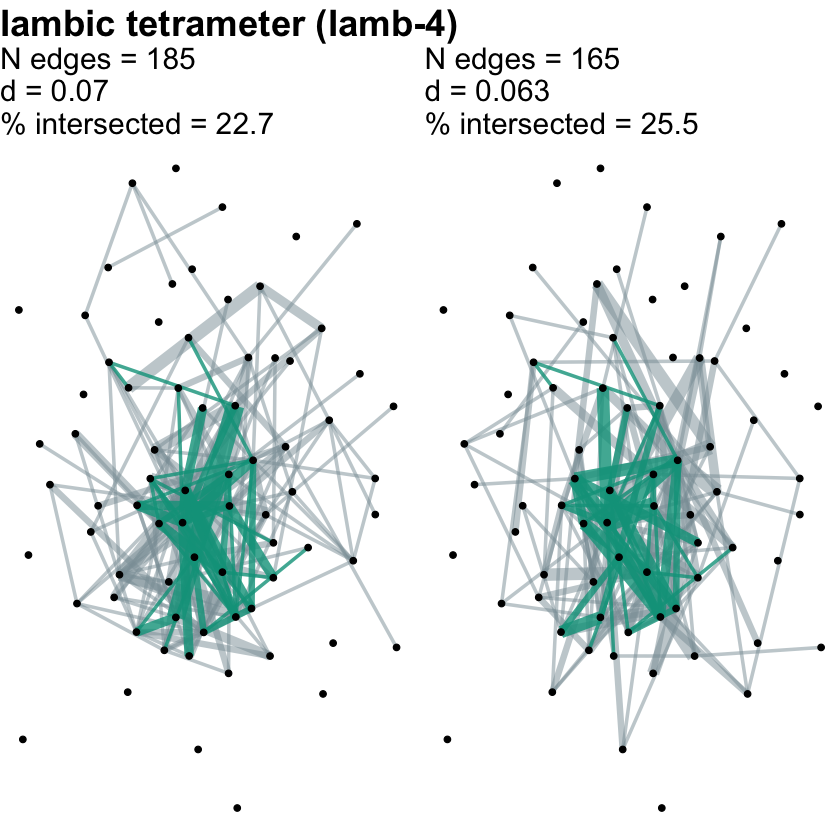

In [31]:
# extract and set labels for the specific meter
labels_df <- meters_stats %>% 
    filter(meter == "iamb_4") 

facet_labels <- setNames(as.character(labels_df$label), labels_df$corpus_fullname)


p_i4 <- network_labels(net1830, "iamb_4", c(wes_palette("Darjeeling1")[2], 
                                    wes_palette("Royal1")[1])) + 
    ggtitle("Iambic tetrameter (Iamb-4)")

p_i4

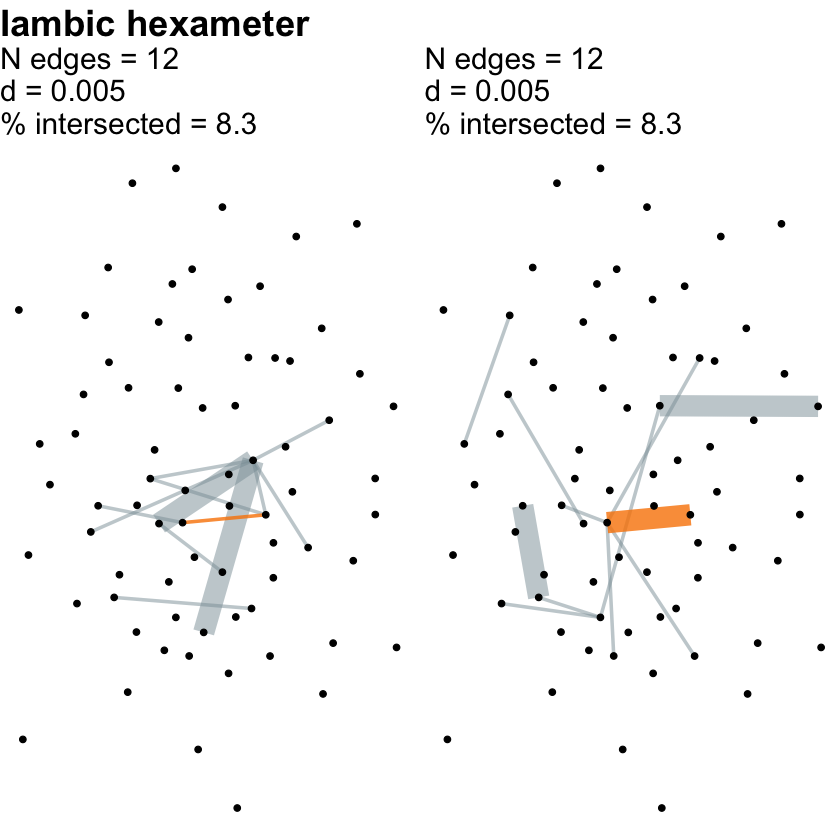

In [32]:
labels_df <- meters_stats %>% 
    filter(meter == "iamb_6") 

facet_labels <- setNames(as.character(labels_df$label), labels_df$corpus_fullname)

p_i6 <- network_labels(net1830, "iamb_6", c(wes_palette("Darjeeling1")[4], 
                                    wes_palette("Royal1")[1])) + 
    ggtitle("Iambic hexameter")

p_i6

RNC 
"N edges = 39\nd = 0.015\n% intersected = 17.9"

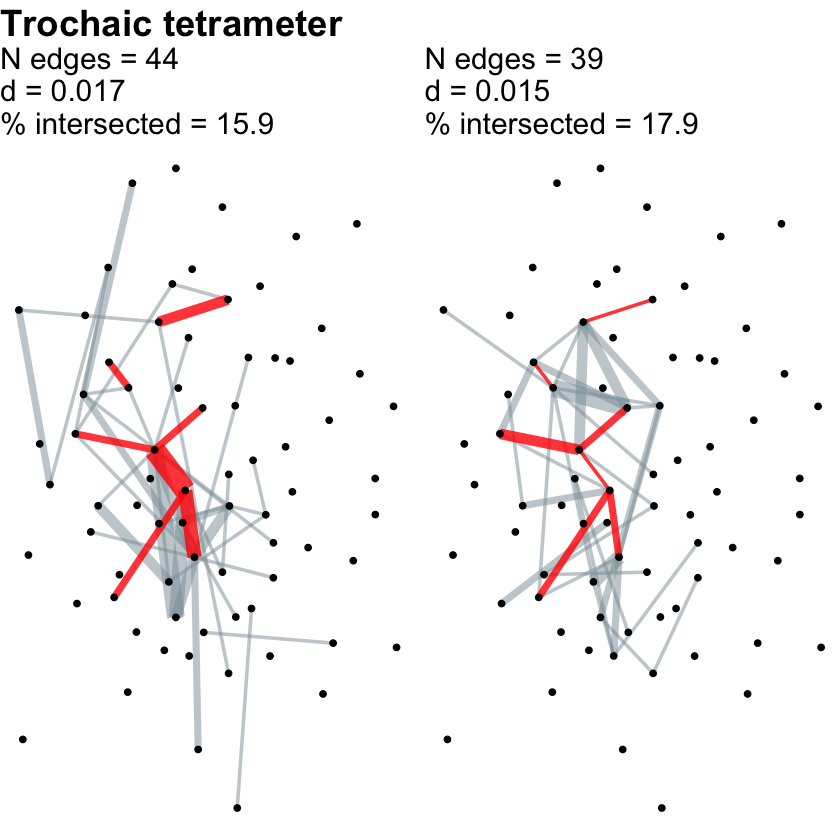

In [33]:
labels_df <- meters_stats %>% 
    filter(meter == "trochee_4") 

facet_labels <- setNames(as.character(labels_df$label), labels_df$corpus_fullname)

facet_labels[1]

p_t4 <- network_labels(net1830, "trochee_4", c(wes_palette("Darjeeling1")[1], 
                                    wes_palette("Royal1")[1])) + 
    ggtitle("Trochaic tetrameter")

p_t4

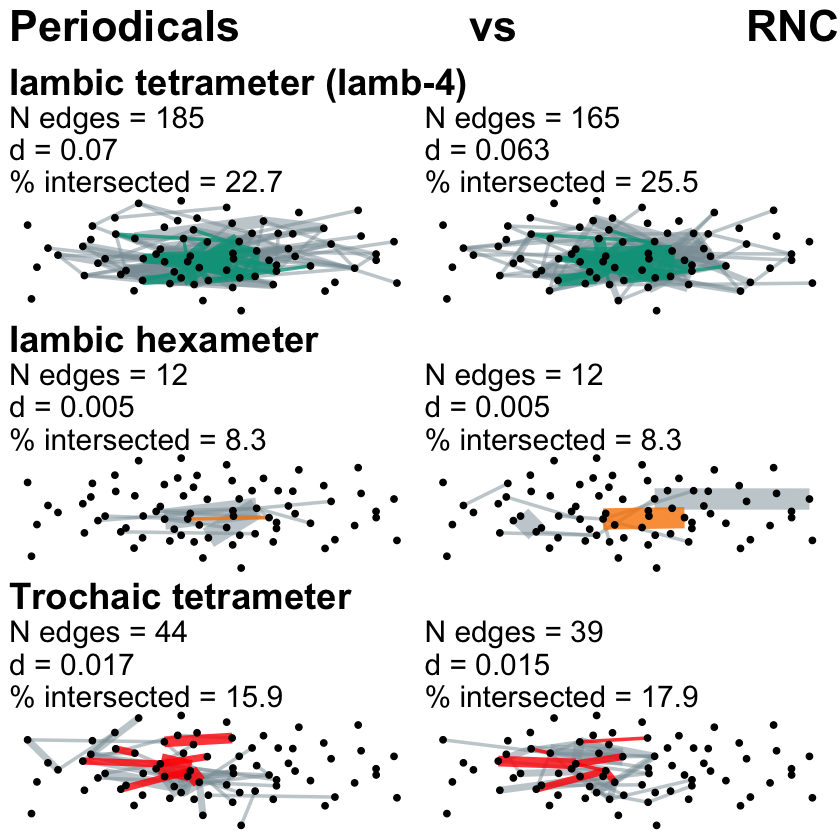

In [35]:
p_i4 / p_i6 / p_t4 + 
    plot_annotation(title = "Periodicals                   vs                   RNC",
                   theme = theme(plot.title = element_text(size = 26,
                                                          face = "bold")))

ggsave(file = "../plots/Fig_4.png", plot = last_plot(),
      dpi = 300, width = 8, height = 16, bg = "white")